In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PyCO2SYS as pyco2
import string
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.optimize import least_squares
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

df = pd.read_csv("../../compilation/data/in_situ_rates_compiled_allvar_uncertainty.csv")

In [2]:
import scipy
scipy.__version__


'1.7.3'

In [3]:
# add uncertainty
df['u_TA_CDisk4'] = 4 # n19
df['u_pH_CDisk4'] = 0.001 # n19
df['u_PO4_CDisk4'] = 0.03 # n19, their uncertainty but 'my' nutrient data
df['u_SiOH4_CDisk4'] = 1.5 # n19, their uncertainty but 'my' nutrient data
df['u_Temp_CDisk4'] = df["Temp_CDisk4"]*0.02 # based on Table 3, GLODAPv2.2022 data
df['u_Sal_CDisk4'] = 0.005 # based on Table 3, GLODAPv2.2022 data


# re-calculate Omega_calc for CDisk so I have the uncertainty
cdisk = pyco2.sys(par1=df["TA_CDisk4"], 
                    par2=df["pH_CDisk4_T25"], 
                    par1_type = 1, par2_type=3, 
                    salinity=df["Salinity_CDisk4"], 
                    temperature_out=df["Temp_CDisk4"], 
                    pressure_out=df["Pressure"],
                    total_silicate=df["SiOH4_cb"], 
                    total_phosphate=df["PO4_cb"],
                  uncertainty_into=["saturation_calcite_out", "saturation_aragonite_out"],
                  uncertainty_from={
                      "par1": df['u_TA_CDisk4'],
                      "par2": df['u_pH_CDisk4'],
                      "salinity": df['u_Sal_CDisk4'] ,                   
                      "temperature": df['u_Temp_CDisk4'],
                      "total_silicate": df['u_SiOH4_CDisk4'],
                      "total_phosphate": df['u_PO4_CDisk4']})


df["pH_insitu_CDisk4"] = cdisk['pH_out']

# calculated myself
df["Oca_CDisk4_calc13_calc"] = cdisk['saturation_calcite_out']
df["Oar_CDisk4_calc13_calc"] = cdisk['saturation_aragonite_out']
df["u_Oca_CDisk4_calc13_calc"] = cdisk['u_saturation_calcite_out']
df["u_Oar_CDisk4_calc13_calc"] = cdisk['u_saturation_aragonite_out']


df["Omega_CDisk4_calc13_calc"] = np.where(df["Material"].eq("Aragonite"), 
                                             df["Oar_CDisk4_calc13_calc"], df["Oca_CDisk4_calc13_calc"])
df["u_Omega_CDisk4_calc13_calc"] = np.where(df["Material"].eq("Aragonite"), 
                                             df["u_Oar_CDisk4_calc13_calc"], df["u_Oca_CDisk4_calc13_calc"])


# make new column for Omega I use (estimated for all except the CDisK-IV ones)
df["Omega_use"] = np.where(df["Omega_CDisk4_calc13"].isna(), 
                                             df["Omega_calc23"], df["Omega_CDisk4_calc13"])
df["u_Omega_use"] = np.where(df["u_Omega_CDisk4_calc13_calc"].isna(), 
                                             df["u_Omega_calc23"], df["u_Omega_CDisk4_calc13_calc"])

## Example how erf-function merges two linear functions together 

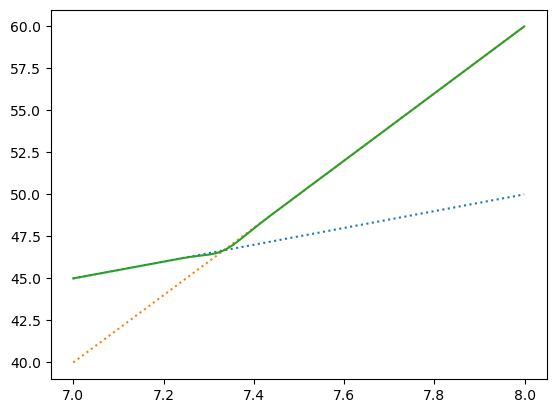

In [4]:
x = np.arange(7,8,0.001)

f1 = 5*x+10 # slower dissolution regime
f2 = 20*x-100 # faster dissolution regime

plt.figure(dpi=100)
plt.plot(x, f1, linestyle="dotted")
plt.plot(x, f2, linestyle="dotted")

# x_tp is thex where f1(x) = f2(x) and this is essentially omega_crit that I am looking for
# for functions of the form ax+b it is calculated (b2-b1)/(a2-a1)
x_tp = -110/15
plt.plot(x, (0.5*(erf((x+x_tp)*20)+1)*f2)+(0.5*(-erf((x+x_tp)*20)+1)*f1))


# Use it on data

## sort data in samplesets

In [5]:
sampleset = []

for source in df["Source_abbrev"].unique():    
    for stype in df[df["Source_abbrev"] == source]["Sample"].unique():  
        for organics in df[(df["Source_abbrev"] == source) & (df["Sample"] == stype)]["Organics"].unique(): 
            for size in df[(df["Source_abbrev"] == source) & (df["Sample"] == stype)]["Size"].unique():                  
                # not enough datapoints (he78) or no omega (Mg calcite)
                if (source != "HE78") & (stype != "Mg-calcite ooids"):
                    sampleset.append([source, stype, organics, size])
                    
print(len(sampleset))

30


## function for input and output variables

In [6]:
# x and y are in log10
def determine_xy(df_sset):
    # mg cm-2 d-1 is preferred
    if pd.isna(df_sset["Rate_sa"]).any() == False:
        df_sset = df_sset[df_sset["Rate_sa"] > 0]
        x = np.log10(1-df_sset["Omega_use"])
        y = np.log10(df_sset["Rate_sa"])
        y_all = np.log10(df["Rate_sa"])
        unit = "mg cm-2 d-1"
    # % d-1
    else:
        df_sset = df_sset[df_sset["Rate_mass"] > 0]
        x = np.log10(1-df_sset["Omega_use"])
        y = np.log10(df_sset["Rate_mass"])
        y_all = np.log10(df["Rate_mass"])
        unit = "% d-1"        
    return x,y,y_all,unit

## write the objective function

$r = k \cdot (1-\Omega)^n$

it needs to be a linear function in the form of $a\cdot\Omega + b$

for one dissolution regime: $\log_{10}(r) = n \cdot \log_{10}(1-\Omega) + \log_{10}(k)$, fitting n and k

In [7]:
def calc_xtp(coef):    
    a1,b1,a2,b2 = coef
    return (b1-b2)/(a2-a1)

def objective(coef, x): 
    n1, k1_log, n2, k2_log = coef
    f1 = n1*x + k1_log
    f2 = n2*x + k2_log
    x_tp = calc_xtp(coef)
    p = 80
    return (0.5*(erf((x-x_tp)*p)+1)*f2)+(0.5*(-erf((x-x_tp)*p)+1)*f1)


def lsqfunc_objective(coef, x, y):
    return objective(coef, x) - y

# initial guess
guess = [0, -3.5, 3, -1.5]


## P66 (Figure 12a)

[ 0.08978324 -3.99318378  3.26329678 -1.63989536]

/Users/ben/opt/anaconda3/envs/base-clone/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)



0.7719424604459288
0.20684665019079104


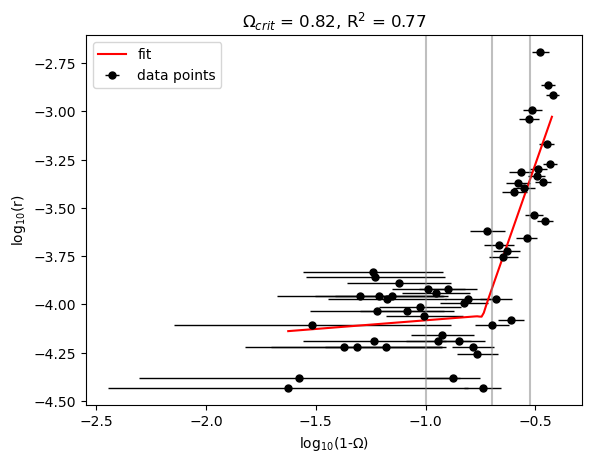

In [8]:
sset = sampleset[0]

df_set = df[(df["Source_abbrev"] == sset[0]) & (df["Sample"] == sset[1]) & (df["Organics"] == sset[2]) & 
                ((pd.isna(df["Size"])) | (df["Size"] == sset[3])) & (df["Omega_calc23"] < 0.99)] 
# determine x, y
x, y, y_all, unit = determine_xy(df_set)

xerr = df_set["u_Omega_use"]/((1-df_set["Omega_use"])*np.log(10))
plt.errorbar(x,y, xerr=xerr, fmt='.', color="black", ms=10, label='data points', lw=1)

#plt.scatter(x,y, color="black", size=15, label='data points')

# make the fit
result = least_squares(lsqfunc_objective, guess, args=(x,y), loss='linear')
print(result.x)

# calculate x-range
x_line = np.arange(min(x), max(x), 0.01)
# calculate output (rate) for x-range
y_line = objective(result.x, x_line)
# line plot for mapping function}
plt.plot(x_line, y_line, color="red", label='fit')

# my estimate based on what seems sensible
#f1 = 0*x_line-4 # slower dissolution regime
#f2 = 2.5*x_line-1.6 # faster dissolution regime
#plt.plot(x_line, (0.5*(erf((x_line+2.4/2.5)*10)+1)*f2)+(0.5*(-erf((x_line+2.4/2.5)*10)+1)*f1), label='my estimation')
plt.xlabel("log$_{10}$(1-$\Omega$)")
plt.ylabel("log$_{10}$(r)")

y_pred = objective(result.x, x)
print(r2_score(y, y_pred))
print(mean_squared_error(y, y_pred, squared=False))

plt.title("$\Omega_{crit}$ = "+ str(round(1-10**(calc_xtp(result.x)),2))+ 
                 ", R$^2$ = " +str(round(r2_score(y, y_pred), 2)))

#helping lines
plt.axvline(np.log10(1-0.9), color='grey', alpha=0.5)
plt.axvline(np.log10(1-0.8), color='grey', alpha=0.5)
plt.axvline(np.log10(1-0.7), color='grey', alpha=0.5)

plt.legend()
plt.show()

## M82 (Figure 12 b - f)

/Users/ben/opt/anaconda3/envs/base-clone/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ben/opt/anaconda3/envs/base-clone/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ben/opt/anaconda3/envs/base-clone/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ben/opt/anaconda3/envs/base-clone/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ben/opt/anaconda3/envs/base-clone/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*

[ 0.67093728 -1.25831367  4.06377859  1.11195702]
0.940063256784903
0.07743863783158456

[ 0.41563626 -1.00281176  4.96994058  2.0894692 ]
0.8538787539167234
0.11534719519198143

[-0.39956323 -1.61839332  3.56056276  1.40836408]
0.9157928863824273
0.07647219748816218

[-0.07160947 -1.27866615  4.85889961  2.1230563 ]
0.7637046851272373
0.13219526507638948



/Users/ben/opt/anaconda3/envs/base-clone/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ben/opt/anaconda3/envs/base-clone/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[-0.31691552 -1.36913667  1.71653539  0.3842296 ]
0.7158382525698604
0.112789889621959



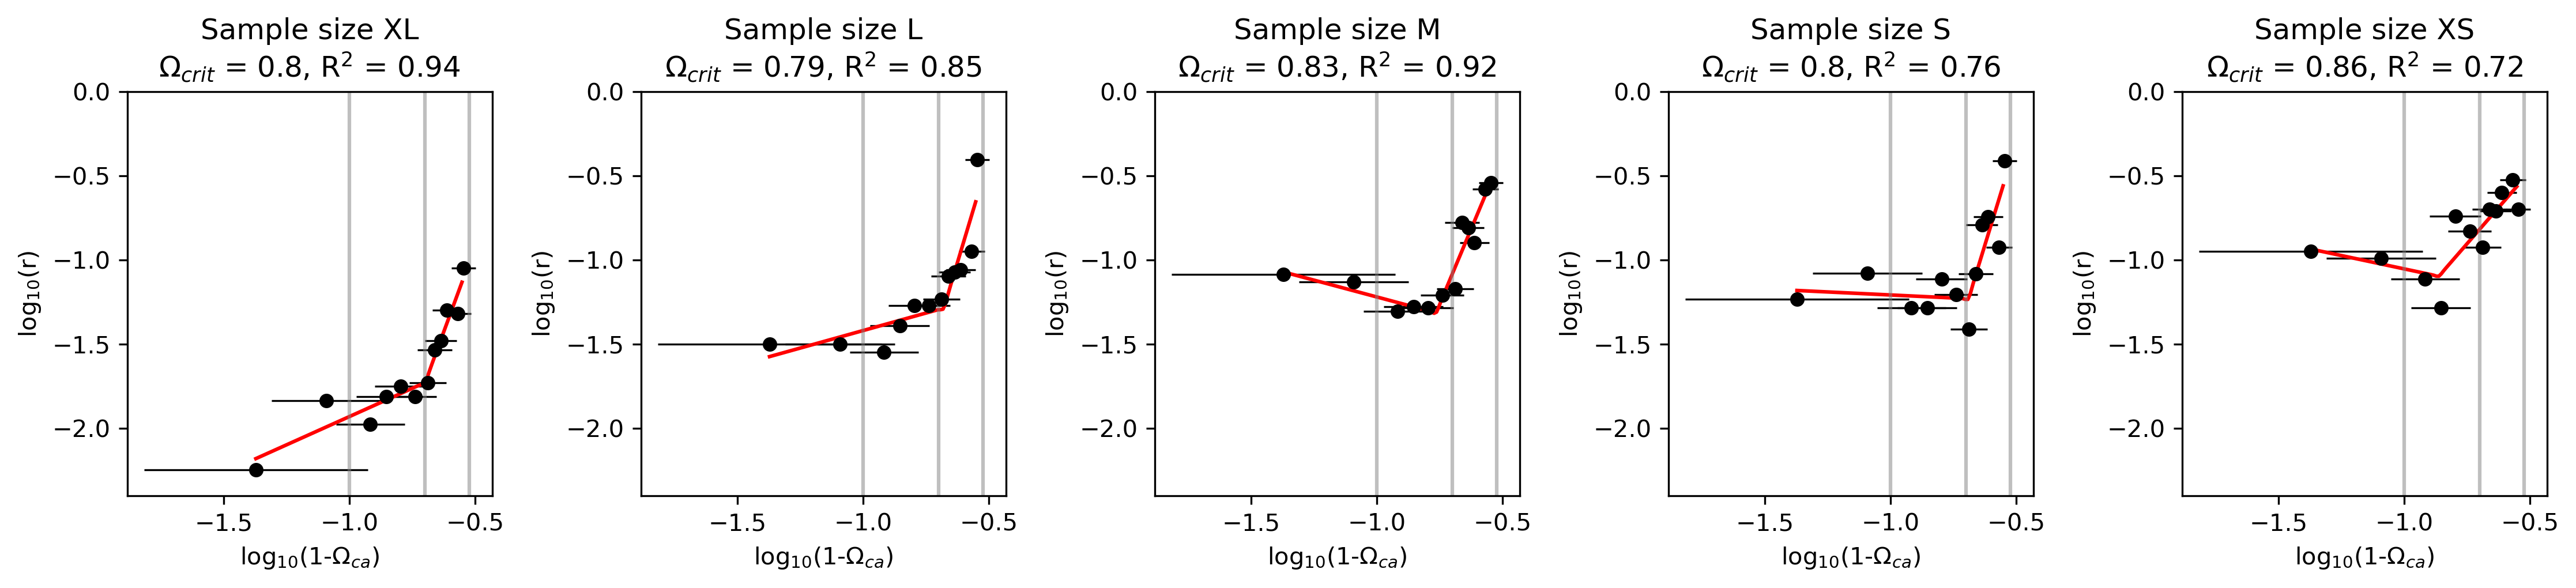

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=5, dpi=300, figsize=(15,3.5))

for sset, ax in zip(sampleset[6:11], axs.ravel()):
    
    # make dataset
    df_set = df[(df["Source_abbrev"] == sset[0]) & (df["Sample"] == sset[1]) & (df["Organics"] == sset[2]) & 
                ((pd.isna(df["Size"])) | (df["Size"] == sset[3])) & (df["Omega_calc23"] < 0.99)]  
    
    
    # choose input and output variables
    x, y, y_all, unit = determine_xy(df_set)

    xerr = df_set["u_Omega_use"]/((1-df_set["Omega_use"])*np.log(10))
    ax.errorbar(x,y, xerr=xerr, fmt='.', color="black", ms=10, label='data points', lw=0.8)

    #ax.scatter(x,y, color="black", s=15, label='data points')

    # make the fit
    result = least_squares(lsqfunc_objective, guess, args=(x,y), loss='linear')
    print(result.x)

    # calculate x-range
    x_line = np.arange(min(x), max(x), 0.01)
    # calculate output (rate) for x-range
    y_line = objective(result.x, x_line)
    # line plot for mapping function}
    ax.plot(x_line, y_line, color="red", label='fit')

    # my estimate based on what seems sensible
    f1 = 0*x_line-4 # slower dissolution regime
    f2 = 2.5*x_line-1.6 # faster dissolution regime
    #plt.plot(x_line, (0.5*(erf((x_line+2.4/2.5)*10)+1)*f2)+(0.5*(-erf((x_line+2.4/2.5)*10)+1)*f1), label='my estimation')
    ax.set_xlabel("log$_{10}$(1-$\Omega_{ca}$)")
    ax.set_ylabel("log$_{10}$(r)")
    
    #helping lines
    ax.axvline(np.log10(1-0.9), color='grey', alpha=0.5)
    ax.axvline(np.log10(1-0.8), color='grey', alpha=0.5)
    ax.axvline(np.log10(1-0.7), color='grey', alpha=0.5)
    
    ax.set_ylim(-2.4,0)

    y_pred = objective(result.x, x)
    print(r2_score(y, y_pred))
    print(mean_squared_error(y, y_pred, squared=False))
    print()

    ax.set_title("Sample size "+sset[3]+"\n$\Omega_{crit}$ = "+ str(round(1-10**(calc_xtp(result.x)),2))+ 
                 ", R$^2$ = " +str(round(r2_score(y, y_pred), 2)))

#axs[0].legend()
plt.tight_layout()
plt.show()

## make plots for all samplesets (Figure S17)

/Users/ben/opt/anaconda3/envs/base-clone/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ben/opt/anaconda3/envs/base-clone/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[ 0.08978324 -3.99318378  3.26329678 -1.63989536]
[ 1.14533532 -0.18086848  3.52298077  1.02031372]
[ 1.16368349 -0.25413469  1.30672677 -0.12170384]
[-2.27018365 -4.36079809  2.09191888 -0.00760066]
[-2.93295794 -5.73017385  2.24998027 -0.22455666]
[-0.29808615 -1.72605908  2.59236181  0.56516841]
[ 0.67093728 -1.25831367  4.06377859  1.11195702]
[ 0.41563626 -1.00281176  4.96994058  2.0894692 ]
[-0.39956323 -1.61839332  3.56056276  1.40836408]
[-0.07160947 -1.27866615  4.85889961  2.1230563 ]
[-0.31691552 -1.36913667  1.71653539  0.3842296 ]
[  -1.57465002   -5.91349755 -170.14995754 -172.58017696]
[  0.         -17.65789581   1.96745243   0.08733101]
[  0.         -10.3550872    1.32027332  -0.46858497]
[ 0.         -5.47740069  4.2748432   0.08235767]
[-3.84945962 -3.61367073  1.26677045  0.03874569]
[ 2.1613679  29.46507459  0.90892842 -0.50971691]
[-2.28859753 -2.96964474  1.30342209 -0.5583535 ]
[1.3116497  0.06357964 6.79346116 2.52225979]
[1.31904069 0.16401904 7.99957152 2.90

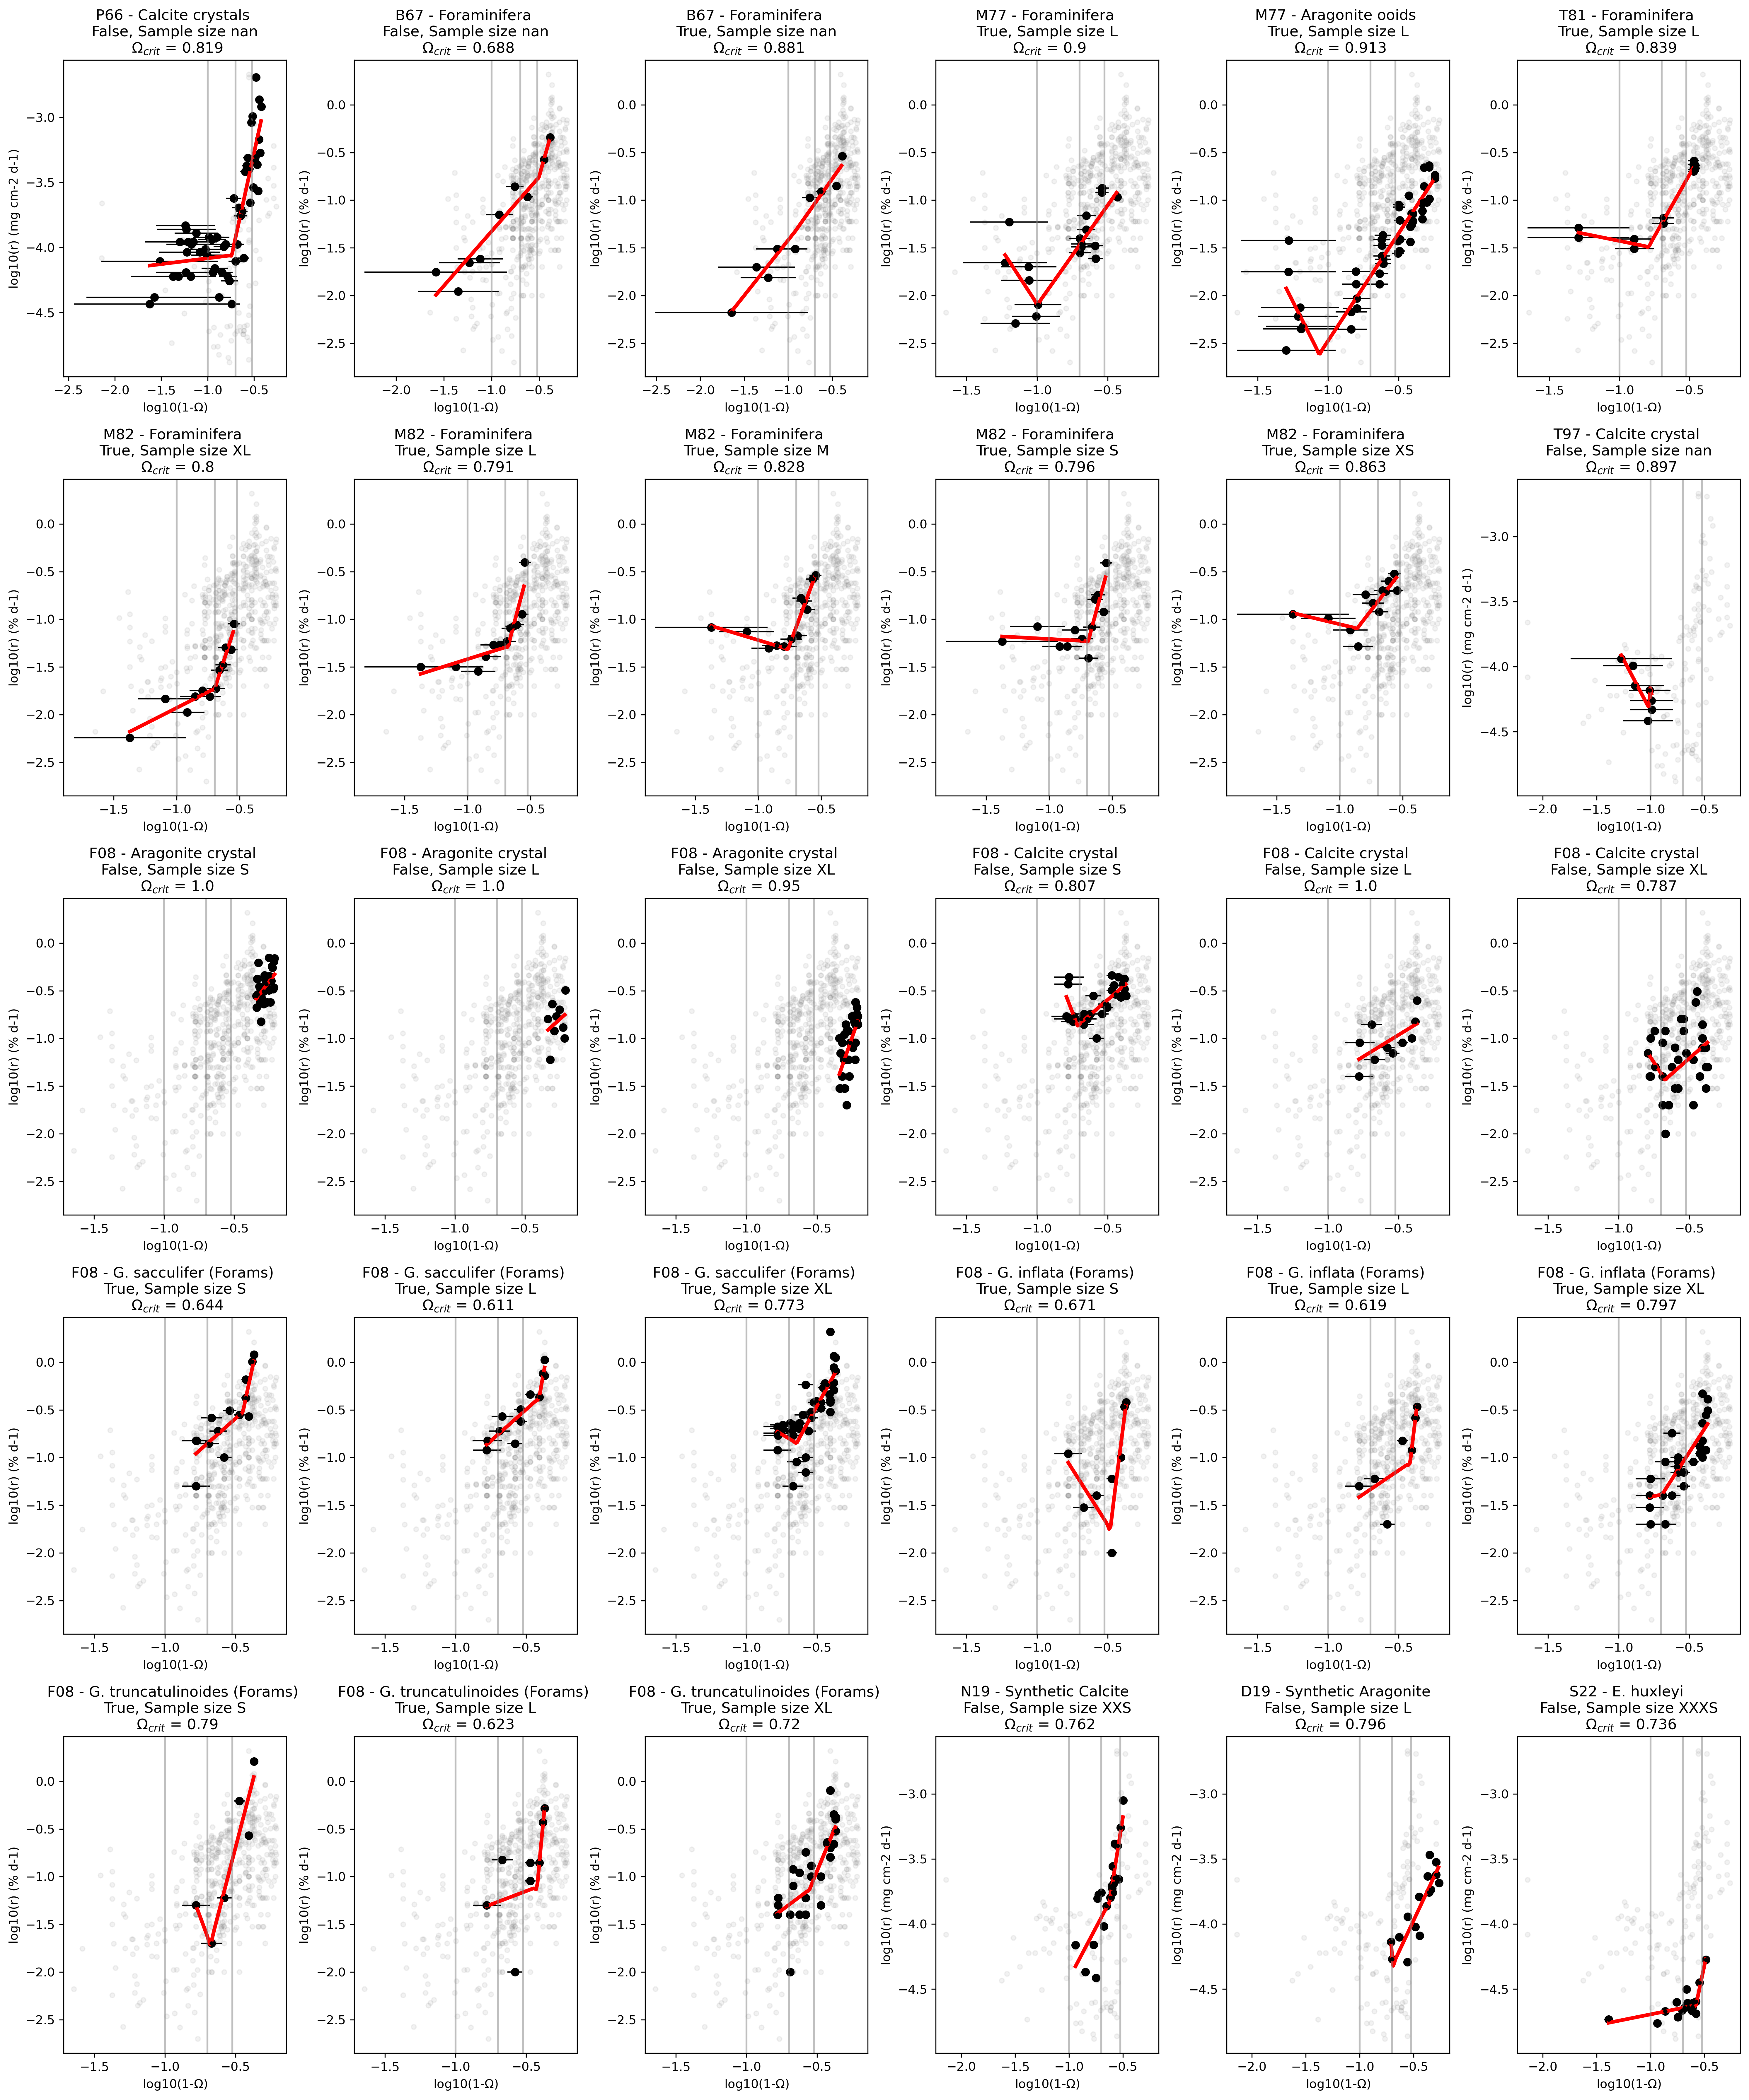

In [10]:
omega_arr = []

fig, axs = plt.subplots(nrows=5, ncols=6, dpi=300, figsize=(20,24))

for sset, ax in zip(sampleset, axs.ravel()):
    
    #print(sset)
    
    # make dataset
    df_set = df[(df["Source_abbrev"] == sset[0]) & (df["Sample"] == sset[1]) & (df["Organics"] == sset[2]) & 
                ((pd.isna(df["Size"])) | (df["Size"] == sset[3])) & (df["Omega_calc23"] < 0.99)]  
    
    
    # choose input and output variables
    x, y, y_all, unit = determine_xy(df_set)
    #plot all data for that unit
    x_all = np.log10(1-df["Omega_use"])
    ax.scatter(x_all, y_all, s=15, color="grey", alpha=0.1)
    
    try:
        xerr = df_set["u_Omega_use"]/((1-df_set["Omega_use"])*np.log(10))
        ax.errorbar(x,y, xerr=xerr, fmt='.', color="black", ms=5, label='data points', lw=1)
    except:
        ax.scatter(x,y, color="black")
    
    try:
        # curve fit
        result = least_squares(lsqfunc_objective, guess, args=(x,y), loss='linear')
        print(result.x)
        # plot input vs output
        ax.scatter(x,y, color="black")
        # define sequence of inputs between smallest and largest input
        x_line = np.arange(min(x), max(x), 0.01)
        # calculate output for range
        y_line = objective(result.x, x_line)
        # line plot for mapping function
        ax.plot(x_line, y_line, color="red", linewidth=3)
        # vertical line for Omega = 0.8
        ax.axvline(np.log10(1-0.9), color='grey', alpha=0.5)
        ax.axvline(np.log10(1-0.8), color='grey', alpha=0.5)
        #ax.axvline(np.log10(1-0.84), color='blue', alpha=0.5)
        ax.axvline(np.log10(1-0.7), color='grey', alpha=0.5)
        # calculate Omega_crit
        o = 1-(10**calc_xtp(result.x))
        omega_arr.append(round(o,3))
        # calculate R2: 
        #y_pred = objective(result.x, x)
        #r2 = r2_score(y, y_pred)
        # title 
        #title = (str(sset) + "\n $\Omega_{crit}$ = "+ str(round(o,3)) 
                 #+ '  R2: ' + str(round(r2),2)
         #       )
        title = (sset[0] + ' - ' +  sset[1] + ' \n' + str(sset[2]) + ', Sample size ' + str(sset[3]) + 
                 "\n $\Omega_{crit}$ = "+ str(round(o,3)) 
                )
        ax.set_title(title)
    except:
        # plot input vs output
        ax.scatter(x,y, color="black")
    ax.set_xlabel("log10(1-$\Omega$)")
    ax.set_ylabel("log10(r) ("+unit+")")
    
    
plt.tight_layout()
plt.show()

In [11]:
omega_arr
print("Number of sets with Omega_crit above 1: " + str(len([x for x in omega_arr if x >= 1])))
print("Number of sets with Omega_crit below 0.5: " + str(len([x for x in omega_arr if x <= 0.5])))
# in between
omega_crit = [x for x in omega_arr if (x <= 0.98) & (x >= 0.5)]
print("Number of sets with Omega_crit in between: " + str(len(omega_crit)))
print(np.mean(omega_crit), np.std(omega_crit))

Number of sets with Omega_crit above 1: 3
Number of sets with Omega_crit below 0.5: 0
Number of sets with Omega_crit in between: 27
0.7815185185185186 0.09130590438511077


# Make one plot for all biogenic samples (Figure 13)
variance of fitted parameters are the diagonals of the covariance matrix 

In [12]:
from autograd import numpy as np, jacobian
from autograd.extend import primitive, defvjp
from scipy.special import erf

In [13]:
def func(x, n1, k1_log, n2, k2_log):    
    def calc_xtp(a1,b1,a2,b2):    
        return (b1-b2)/(a2-a1)
    
    f1 = n1*x + k1_log
    f2 = n2*x + k2_log
    x_tp = calc_xtp(n1, k1_log, n2, k2_log)
    p = 80
    return (0.5*(myerf((x-x_tp)*p)+1)*f2) + (0.5*(-myerf((x-x_tp)*p)+1)*f1)


def calc_xtp(coef):
    a1, b1, a2, b2 = coef
    return (b1 - b2) / (a2 - a1)


def objective(coef, x):
    n1, k1_log, n2, k2_log = coef
    f1 = n1 * x + k1_log
    f2 = n2 * x + k2_log
    x_tp = calc_xtp(coef)
    p = 80
    return (0.5 * (myerf((x - x_tp) * p) + 1) * f2) + (
        0.5 * (-myerf((x - x_tp) * p) + 1) * f1
    )


In [14]:
@primitive
def myerf(x):
    return erf(x)


def derf_dx(x):
    return (2 / np.sqrt(np.pi)) * np.exp(-(x**2))


def _derf_vjp(ans, x):
    return lambda g: g * derf_dx(x)


defvjp(myerf, _derf_vjp)

In [15]:
df_set = df[(df['Rate_mass'].isna() == False) & (df["Omega_calc23"] < 0.99)
           & (df["Biogenic"] == True)]

# determine x, y
# x is log10(Omega)
# y is log10(rate)
x, y, y_all, unit = determine_xy(df_set)

rate_fit = curve_fit(func, x, y, p0=guess)

coefs = rate_fit[0]
print(coefs)
print()
cov_matrix = rate_fit[1]
print('standard deviation:')
print(np.sqrt(np.diag(cov_matrix)))

[ 0.68577846 -0.61942453  2.23149909  0.44225031]

standard deviation:
[0.16230208 0.1532737  0.24302115 0.12879182]


0.46722941796902173


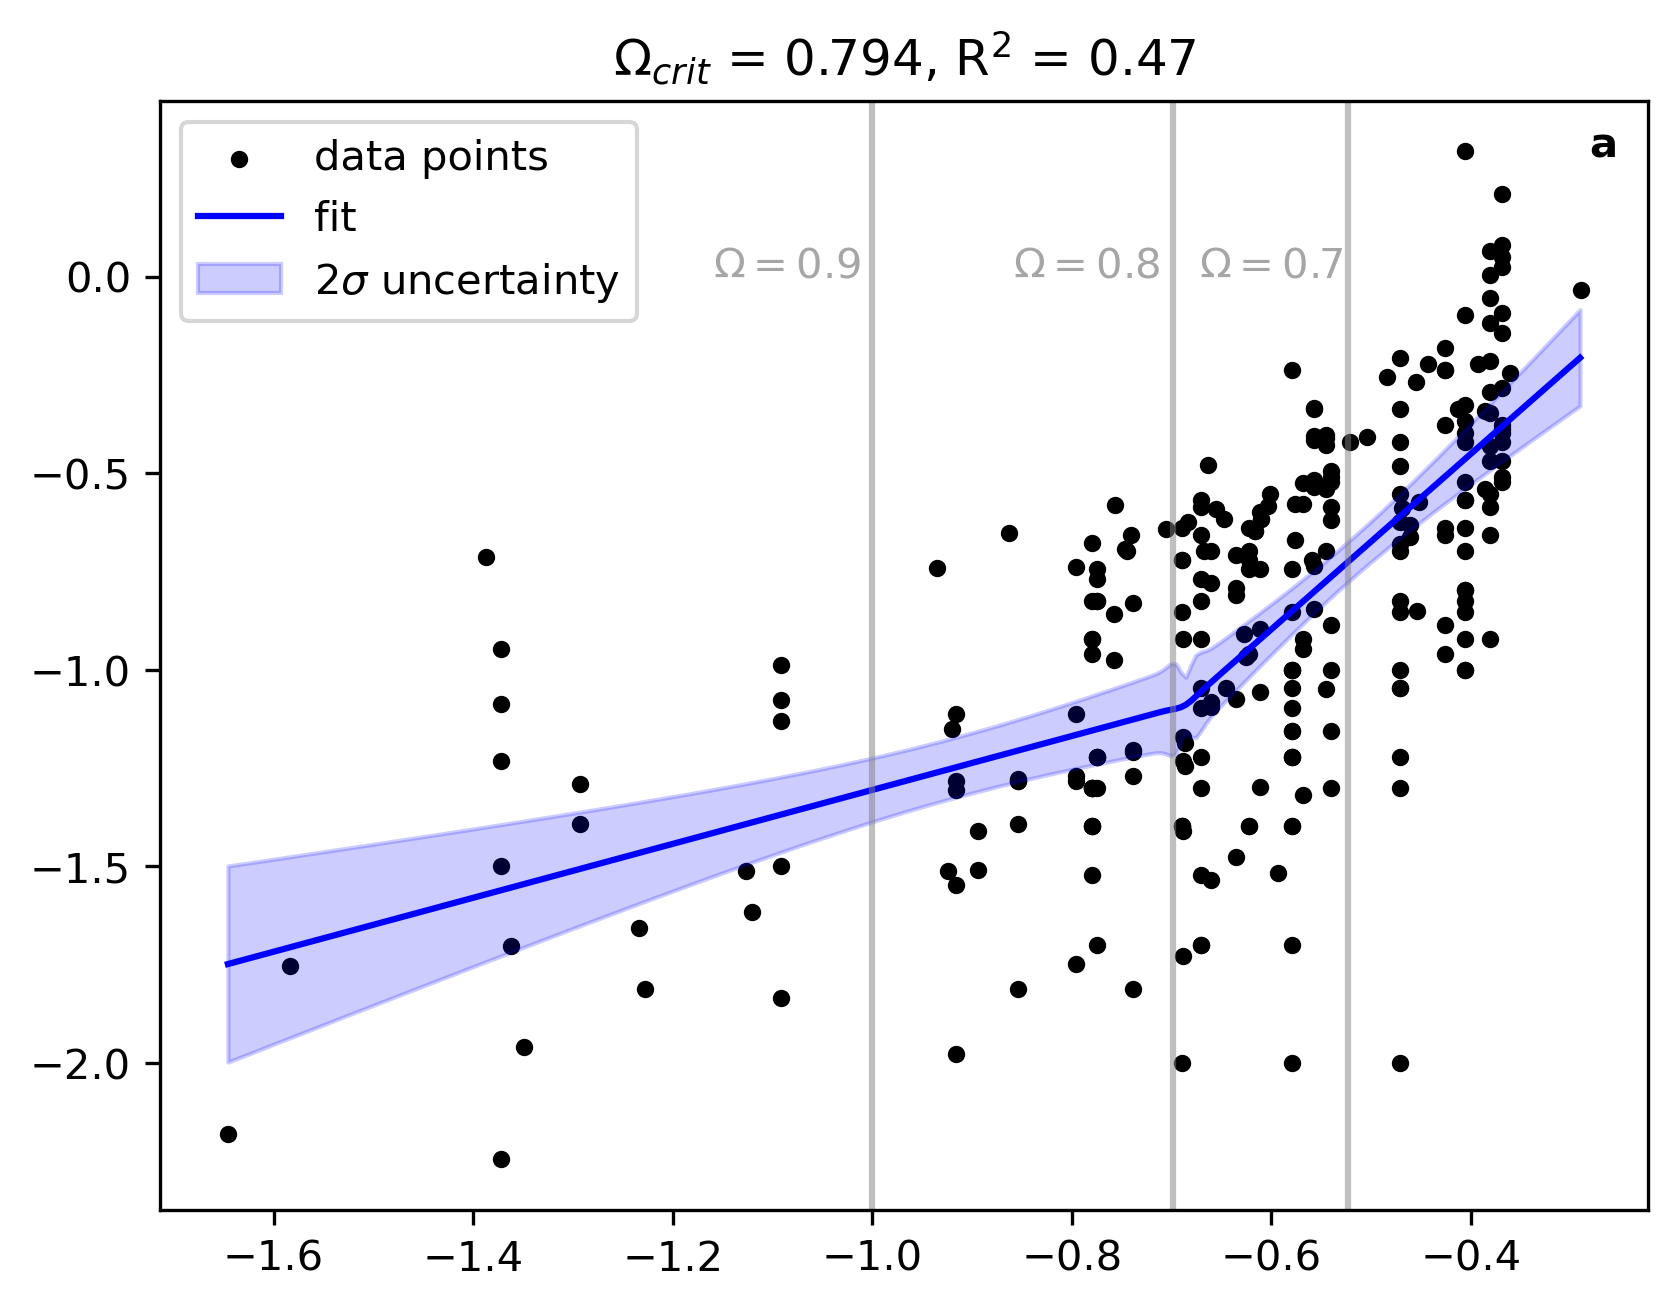

In [16]:
plt.figure(dpi=300)
# calculate x-range
x_line = np.arange(min(x), max(x), 0.005)
# calculate output (rate) for x-range
y_line = objective(coefs, x_line)
# line plot for mapping function}
plt.scatter(x,y, color="black", s=10, label='data points')
plt.plot(x_line, y_line, color="blue", label='fit')

# get uncertainty
jac = jacobian(objective)(coefs, x_line)
uncertainty_lograte = jac @ cov_matrix @ jac.T
uncertainty_1sigma = np.sqrt(np.diag(uncertainty_lograte))

plt.fill_between(x_line, y_line - 2*uncertainty_1sigma, y_line + 2*uncertainty_1sigma, alpha=0.2, color='blue',
                label='2$\sigma$ uncertainty')

plt.legend()

y_pred = objective(coefs, x)
print(r2_score(y, y_pred))

plt.title("$\Omega_{crit}$ = "+ str(round(1-10**(calc_xtp(coefs)),3))+ 
                 ", R$^2$ = " +str(round(r2_score(y, y_pred), 2))
        # + '\n linear: R$^2$ = ' +str(round(r2_score(y, model.predict(x_r)), 2))
         )


#helping lines
plt.axvline(np.log10(1-0.9), color='grey', alpha=0.5)
plt.axvline(np.log10(1-0.8), color='grey', alpha=0.5)
plt.axvline(np.log10(1-0.7), color='grey', alpha=0.5)

plt.text(np.log10(1-0.9)-0.16, 0, '$\Omega=0.9$', color='grey', alpha=0.7)
plt.text(np.log10(1-0.8)-0.16, 0, '$\Omega=0.8$', color='grey', alpha=0.7)
plt.text(np.log10(1-0.7)-0.15, 0, '$\Omega=0.7$', color='grey', alpha=0.7)


plt.annotate('a', (0.96, 0.95), xycoords='axes fraction', weight='bold')

plt.show()